# 한글 스팸 이메일 분류

## 1. 데이터 불러오기
## 2. 피처 엔지니어링 (5개 이상의 피처를 생성)
## 3. 탐색적 데이터 분석(EDA)을 통한 시각화
## 4. 학습 및 테스트 데이터 분할
## 5. 여러 분류 모델(Decision Tree, XGBoost, Logistic Regression 등)로 학습
## 6. 모델 성능 비교 및 시각화
## 7. 사용자 입력에 대한 스팸 여부 예측 함수 작성

In [7]:
%pip install pandas googletrans==4.0.0-rc1 numpy scikit-learn xgboost matplotlib seaborn

  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.8 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinu

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


## 0. 데이터 수집

학습에 사용하기 위한 데이터로는 kaggle에 있는 영문 이메일 데이터 셋을 한글로 번역한 데이터와 한글 스팸 이메일 데이터를 사용하였습니다.

In [9]:
import pandas as pd
from googletrans import Translator

In [10]:
input_csv = 'emails.csv'
df = pd.read_csv(input_csv)

In [11]:
# Initialize the translator
translator = Translator()

# Define a function to translate text from English to Korean.
def translate_text(text):
    try:
        # Translate the text to Korean (dest='ko')
        translation = translator.translate(text, dest='ko')
        return translation.text
    except Exception as e:
        print("Error translating text:", text, e)
        return text

In [12]:
# Apply the translation function to the "text" column.
df['text'] = df['text'].apply(translate_text)

# Save the translated dataset to a new CSV file.
output_csv = 'spam_translated.csv'
df.to_csv(output_csv, index=False)
print("Translation complete. Translated file saved as", output_csv)

Error translating text: Subject: here ' s a hot play in motion  homeland security investments  the terror attacks on the united states on september 11 , 20 ol have  changed  the security landscape for the foreseeable future . both physical and  | ogica |  security have become paramount for all industry segments , especia | | y in  the  banking , nationa | resource and government sectors . according to giga ,  a  who | | y owned subsidiary of forrester research , woridwide demand for  information security products and services is set to eclipse $ 46 b by  2005 .  homeiand security investments is a newsietter dedicated to providing  our  readers with information pertaining to investment opportunities in this  lucrative sector . as we know , events related to homeland security  happen  with lightning speed . what we as investors can do is position  ourselves in  such a way as to take advantage of the current trends and be ready to  capitalize on events which have yet to happen . homeland 

# 1. 데이터 불러오기

In [13]:
df = pd.read_csv('spam_translated.csv')  # 'spam_translated.csv' 파일 경로 수정 가능

# spam 컬럼(0/1)과 text(한국어 메일 내용)가 있다고 가정
df.head()

,text,spam
0,제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...,1
1,주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...,1
2,"제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...",1
3,제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...,1
4,제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...,1


# 2. 피처 엔지니어링
 
1) **메일 길이**: 전체 문자의 길이  
2) **단어 수**: 공백 기준으로 나눈 단어의 개수  
3) **대문자(영문) 수**: 영문 대문자의 개수  
4) **숫자(0-9) 수**: 숫자의 개수  
5) **특수문자(!, ?, @ 등)** 수: 특정 특수문자의 개수  
6) **스팸 키워드 포함 횟수**: 예시로 한국어 스팸 메일에서 자주 쓰이는 단어들을 미리 정의 후 포함 횟수 계산  

In [14]:
spam_keywords = ["무료", "당첨", "이벤트", "광고", "회원", "대출", "카드", "보상", "긴급", "특가"]

def count_spam_keywords(text, keywords):
    count = 0
    for kw in keywords:
        count += text.count(kw)
    return count

def feature_engineering(df):
    # 메일 길이
    df['length'] = df['text'].apply(len)
    
    # 단어 수
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    
    # 대문자(영문) 수
    # 한국어 데이터라고 가정했지만, 일부 대문자 영문이 포함될 수 있음
    df['num_upper'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
    
    # 숫자 수
    df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
    
    # 특수문자 수 (예: !, ?, @)
    special_chars = set(['!', '?', '@', '#', '$', '%', '^', '&', '*', '(', ')'])
    df['num_special_chars'] = df['text'].apply(lambda x: sum(c in special_chars for c in x))
    
    # 스팸 키워드 포함 횟수
    df['num_spam_keywords'] = df['text'].apply(lambda x: count_spam_keywords(x, spam_keywords))

    return df

df = feature_engineering(df)
df.head()

,text,spam,length,word_count,num_upper,num_digits,num_special_chars,num_spam_keywords
0,제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...,1,817,241,18,4,1,0
1,주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...,1,287,59,8,0,0,0
2,"제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...",1,215,53,2,9,0,0
3,제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...,1,299,62,20,30,12,1
4,제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...,1,113,21,2,0,2,0


# 3. 탐색적 데이터 분석(EDA)
기본적인 스팸/비스팸 분포 및 생성한 피처에 대한 분포를 시각화합니다.

/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54072 (\N{HANGUL SYLLABLE PAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

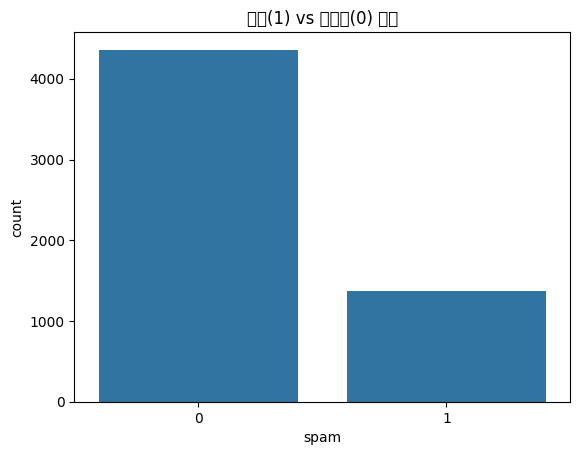

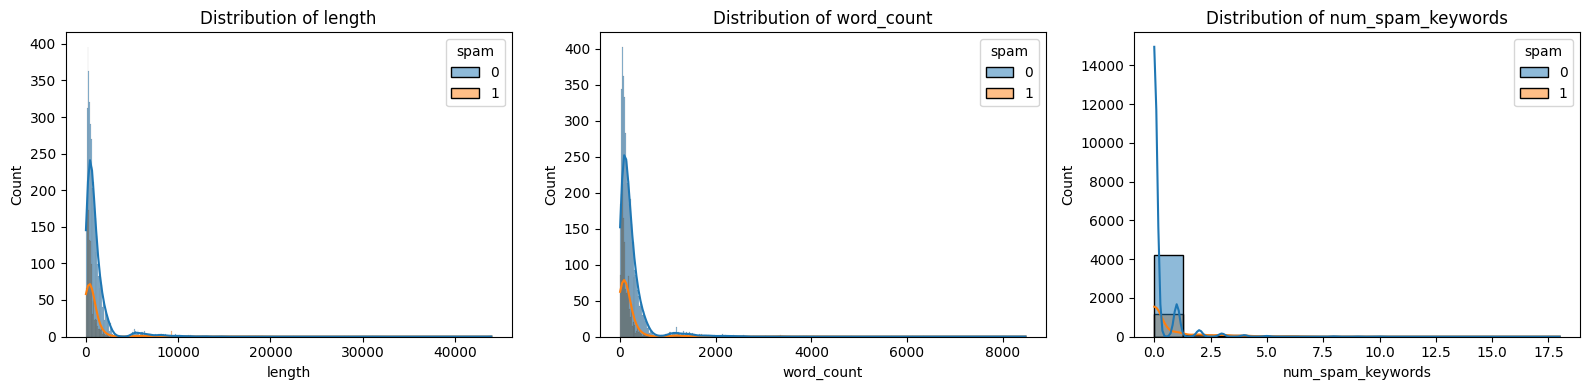

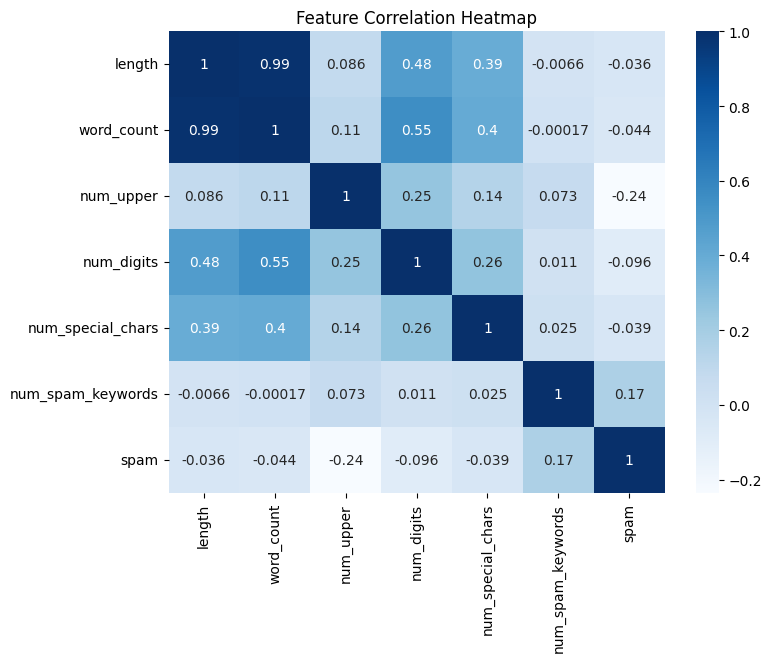

In [15]:
# 스팸/비스팸(0/1) 분포
sns.countplot(x='spam', data=df)
plt.title("스팸(1) vs 비스팸(0) 분포")
plt.show()


# 히스토그램으로 몇 가지 피처 확인
features_to_plot = ['length', 'word_count', 'num_spam_keywords']
fig, axs = plt.subplots(1, len(features_to_plot), figsize=(16,4))

for i, feature in enumerate(features_to_plot):
    sns.histplot(data=df, x=feature, hue='spam', kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


# 피처 간 상관관계(heatmap)
plt.figure(figsize=(8,6))
sns.heatmap(df[['length','word_count','num_upper','num_digits','num_special_chars','num_spam_keywords','spam']].corr(), 
            annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.show()

# 4. 학습 및 테스트 데이터 분할
**Feature(피처)**: 위에서 생성한 수치형 피처들  
**Target(타겟)**: `spam` (0: 비스팸, 1: 스팸)

In [16]:
# 모델 학습에 사용할 피처 설정
feature_cols = ['length', 'word_count', 'num_upper', 'num_digits', 'num_special_chars', 'num_spam_keywords']

X = df[feature_cols]
y = df['spam']

# train, test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("훈련 데이터 크기:", X_train.shape, "테스트 데이터 크기:", X_test.shape)

훈련 데이터 크기: (4582, 6) 테스트 데이터 크기: (1146, 6)


# 5. 여러 분류 모델 학습 및 비교
학습을 위해 다음 5가지 모델들을 사용합니다.

1) Decision Tree  
2) Random Forest  
3) XGBoost  
4) Logistic Regression  
5) Support Vector Machine (SVM)

In [17]:
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()

=== DecisionTree ===
Accuracy: 0.8027923211169284
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       872
           1       0.59      0.59      0.59       274

    accuracy                           0.80      1146
   macro avg       0.73      0.73      0.73      1146
weighted avg       0.80      0.80      0.80      1146

Confusion Matrix:
[[757 115]
 [111 163]]

=== RandomForest ===
Accuracy: 0.8490401396160558
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       872
           1       0.74      0.57      0.64       274

    accuracy                           0.85      1146
   macro avg       0.81      0.75      0.77      1146
weighted avg       0.84      0.85      0.84      1146

Confusion Matrix:
[[816  56]
 [117 157]]

=== XGBoost ===
Accuracy: 0.856020942408377
Classification Report:
              precision    recall  f1-score   sup

/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== SVM ===
Accuracy: 0.7609075043630017
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       872
           1       0.00      0.00      0.00       274

    accuracy                           0.76      1146
   macro avg       0.38      0.50      0.43      1146
weighted avg       0.58      0.76      0.66      1146

Confusion Matrix:
[[872   0]
 [274   0]]



/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

# 6. 모델 성능 비교 및 시각화
accuracy를 기준으로 비교합니다.

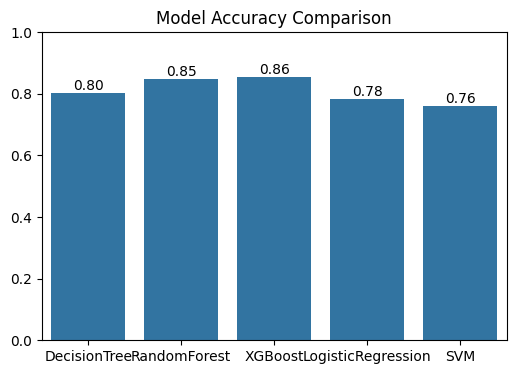

가장 높은 정확도를 보인 모델: XGBoost (정확도: 0.8560)


In [18]:
model_names = list(results.keys())
accuracy_scores = list(results.values())

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=accuracy_scores)
plt.title("Model Accuracy Comparison")
plt.ylim([0,1])
for i, v in enumerate(accuracy_scores):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.show()

best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]

print(f"가장 높은 정확도를 보인 모델: {best_model_name} (정확도: {best_model_score:.4f})")

In [19]:
# 결정 경계 시각화
from sklearn.decomposition import PCA
from sklearn.base import clone

# Define best_model from the models dictionary.
best_model = models[best_model_name]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 베스트 모델을 2차원 PCA 데이터를 이용하여 다시 학습 (시각화를 위한 모델)
best_model_2d = clone(best_model)
best_model_2d.fit(X_train_pca, y_train)

# Mesh grid 생성 (PCA 공간 기준)
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 각 그리드 포인트에 대해 예측
Z = best_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 결정 경계 및 학습 데이터 시각화
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=20, edgecolor='k', label='Train')
plt.title(f"Decision Surface for Best Model (PCA space): {best_model_name}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:42:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


MemoryError: Unable to allocate 167. GiB for an array with shape (50256, 447173) and data type float64

# 7. 사용자 입력에 대한 스팸 여부 예측 함수
아래 함수를 통해, 사용자가 새로운 한국어 이메일 내용을 입력하면 바로 스팸 여부(0/1)를 예측할 수 있습니다.

In [ ]:
best_model = models[best_model_name]

def predict_spam(input_text):
    """
    사용자로부터 이메일 내용을 입력받아 스팸 여부를 예측하는 함수.
    """
    temp_df = pd.DataFrame({'text': [input_text]})
    temp_df = feature_engineering(temp_df)
    
    # 모델에 필요한 피처만 추출
    temp_X = temp_df[feature_cols]
    
    pred = best_model.predict(temp_X)[0]
    return pred  # 0이면 비스팸, 1이면 스팸

# 함수 테스트
test_email = "무료 쿠폰 증정합니다! 지금 클릭하세요!"
result = predict_spam(test_email)
print(f"이메일 내용: {test_email}")
print("예측 결과:", "스팸" if result == 1 else "비스팸")